In [283]:
import numpy as np
import pandas as pd
import re
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import nltk
import nltk.corpus
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [165]:
#load tweet csv
tweets = pd.read_csv(r'C:\Users\peter\metis\vaccination_tweets.csv')
tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [274]:
#print exemplar tweet
row_1=tweets.iloc[1]
print(row_1)
print(row_1['user_description'])
print(row_1['text'])

id                                                1338158543359250433
user_name                                                 Albert Fong
user_location                                       San Francisco, CA
user_description    Marketing dude, tech geek, heavy metal & '80s ...
user_created                                      2009-09-21 15:27:30
user_followers                                                    834
user_friends                                                      666
user_favourites                                                   178
user_verified                                                   False
date                                              2020-12-13 16:27:13
text                While the world has been on the wrong side of ...
hashtags                                                          NaN
source                                                Twitter Web App
retweets                                                            1
favorites           

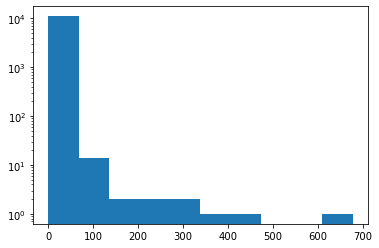

In [280]:
#log scaled retweet distribution
x = tweets.retweets

#plt.hist(np.log(x+1))
plt.hist(x)
plt.yscale('log')
#even after log transformation, distribution of retweets is severely skewed
#not an ideal target for regression prediction

In [5]:
#select three user features
X = tweets.loc[:,'user_followers':'user_favourites']

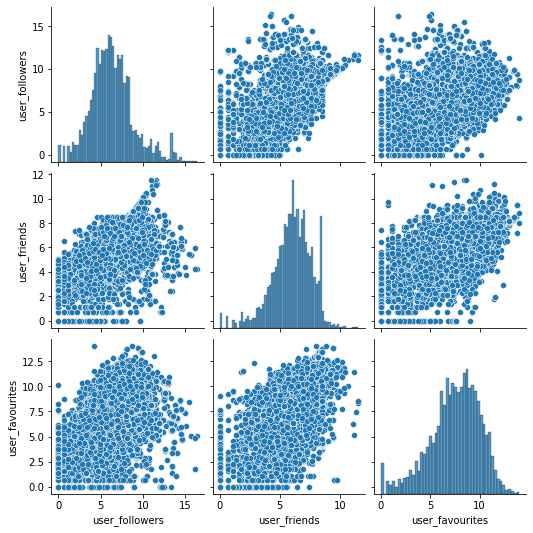

In [6]:
#log-transformed pair plot of user features
sns.pairplot(np.log(X+1))
#unlike retweets, user followers, friends and favorites are close to normal distribution after log transformation

In [7]:
tweets['length'] = tweets['text'].str.len()
tweets['length']

0         97
1        140
2        140
3        140
4        135
        ... 
11015    140
11016     28
11017    140
11018    140
11019    140
Name: length, Length: 11020, dtype: int64

26 151


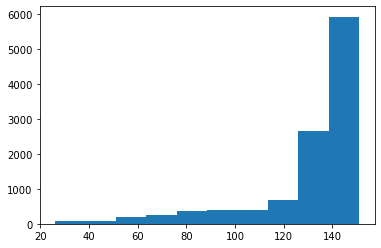

In [8]:
#tweet character length distribution
xlen = tweets.length
plt.hist(xlen)
print(min(xlen), max(xlen))

(array([5009., 1336., 1171.,  566.,  539.,  306.,  535.,  781.,  384.,
         393.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

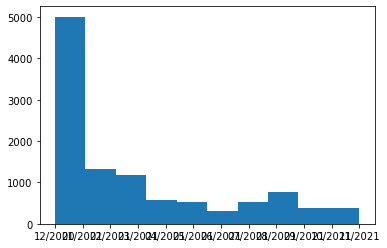

In [272]:
#date analysis
#tweets['date'] =  pd.to_datetime(tweets['date'], format='%Y-%m-%d')
tweets['date'] =  pd.to_datetime(tweets['date'], format='%m/%Y')

#date = tweets.date
#plt.hist(date)
#tweets['date'].dt.month
year_month = tweets['date'].dt.strftime('%m/%Y')
#tweets['date']
year_month
plt.hist(year_month)

In [148]:
#consider unsupervised clustering of user descriptions
docs = tweets.user_description
vec = TfidfVectorizer(stop_words='english')
doc_term = vec.fit_transform(docs.astype('U').values)
doc_term = doc_term.toarray()
vec.vocabulary_
doc_term

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [105]:
#consider unsupervised clustering of text
docs_text = tweets.text
vec_text = TfidfVectorizer(stop_words='english')
doc_term_text = vec_text.fit_transform(docs_text.values)
doc_term_text = doc_term_text.toarray()
vec_text.vocabulary_

{'folks': 9077,
 'said': 19897,
 'daikon': 6446,
 'paste': 17028,
 'treat': 22496,
 'cytokine': 6352,
 'storm': 21222,
 'pfizerbiontech': 17290,
 'https': 10970,
 'xehhimg1kf': 25032,
 'world': 24735,
 'wrong': 24803,
 'history': 10682,
 'year': 25450,
 'hopefully': 10822,
 'biggest': 4075,
 'vaccination': 23515,
 'effort': 7766,
 've': 23747,
 'ev': 8287,
 'dlchrzjkhm': 7056,
 'coronavirus': 5871,
 'sputnikv': 20998,
 'astrazeneca': 3375,
 'moderna': 14928,
 'covid_19': 6005,
 'russian': 19722,
 'vaccine': 23532,
 'created': 6137,
 'years': 25451,
 'ieylckbr8p': 11274,
 'facts': 8590,
 'immutable': 11447,
 'senator': 20244,
 'ethically': 8219,
 'sturdy': 21295,
 'acknowledge': 2472,
 'born': 4339,
 'jqgv18kch4': 12497,
 'explain': 8442,
 'need': 15555,
 'borisjohnson': 4335,
 'matthancock': 14382,
 'whereareallthesickpeople': 24523,
 'kxbsrobehq': 13204,
 'does': 7126,
 'useful': 23308,
 'advice': 2609,
 'guidance': 10129,
 'covid': 5962,
 'safe': 19877,
 'whilst': 24530,
 'breastfeed

PfizerBioNTech coronavirus SputnikV AstraZeneca PfizerBioNTech Moderna Covid_19 whereareallthesickpeople PfizerBioNTech vaccination BidenHarris Election2020 CovidVaccine covid19 PfizerBioNTech Moderna CovidVaccine COVID19Vaccine US pakustv NYC Healthcare GlobalGoals PfizerBioNTech Vaccine COVID19 CovidVaccine vaccine Corona PfizerBioNTech bbcnews NYTimes BBCNews PfizerBioNTech vaccine YellowFever COVID19 ImmunityPassports SARSCoV2 PfizerBioNtech Britain December Iran coronavirus PfizerBioNTech CovidVaccine COVIDIOTS coronavirus CovidVaccine fda vaccine PfizerBioNTech vaccine docnosofficial covid19 ThankYouNHS PfizerBioNTech CovidVaccine stayhome StayAtHome StayAtHomeSaveLives PfizerBioNTech FDA vaccine supplychain sharedvisibility Vaccine TrumpVaccine AstraZeneca PfizerBioNTech Pfizervaccine PfizerCovidVaccine Pfizer CovidVaccines Pfizervaccine ICYMI FDA PfizerBioNTech COVID19 Vaccine covid Pfizervaccine PfizerBioNTech CovidVaccine PfizerBioNTech Pfizervaccine PfizerProud FDA EUA Pfize

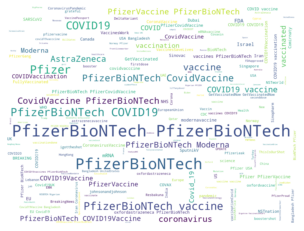

In [11]:
#word cloud of tweet hashtags
#PfizerBioNTech is overwhelmingly common (in every tweet)

out_hashtags = tweets.hashtags.str.cat(sep=', ')
out_hashtags=(''.join(out_hashtags))
out_hashtags = re.sub(r"[\([{})\]]", "", out_hashtags)
out_hashtags = re.sub(r",", "", out_hashtags)
out_hashtags = out_hashtags.replace("'", "")
print(out_hashtags)

stopwords = []

wordcloud_hashtags = WordCloud(
                width = 1600, height = 1200,
                background_color ='white',
                stopwords = '',
                #min_font_size = 8
                              ).generate(out_hashtags)
plt.imshow(wordcloud_hashtags, interpolation='bilinear')
plt.axis("off")
plt.show()

#wordcloud_hashtags.to_file("img/first_review.png")

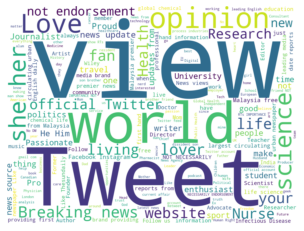

In [12]:
#word cloud of user descriptions
out_users = tweets.user_description.str.cat(sep=', ')
out_users
wordcloud_users = WordCloud(
                width = 1600, height = 1200,
                background_color ='white',
                stopwords = ['https', 'co', 't', 'in', 'I', 'of', 'a', 'with', 'my', 'the', 'at', 'and', 'for', 'own','of',
                             'are', 'is', 'to', 'on', 'it', 'all', 'more', 'that', 'or', 'you', 'by', 'be', 'get', 'but',
                             'what', 'am', 'up', 'will', 'here', 'our', 'me', 'who', 'about', 'm', 'We', 'can', "I'm",
                            'S8jbx5pMaF', 's', 'as', 'If', 'How', 'want', 'only', 'n', 'out', 'so', 'do', 'now', 'way', "E",
                            "xh8S6IJnaB", "don't", 'which', 'u', 'an', 'don', 'gmail com', 'those', 'need'],
                min_font_size = 8,
                colormap = 'viridis'
                              ).generate(out_users)
plt.imshow(wordcloud_users, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_users.to_file("twitter_user_description_word_cloud.png")

In [92]:
#user description clustering, normalize
doc_term_norm = normalize(doc_term)
doc_term_array_norm = doc_term_norm.toarray()

In [98]:
#https://towardsdatascience.com/k-means-clustering-8e1e64c1561c
pd.DataFrame(doc_term_array_norm, columns=vec.get_feature_names_out()).head()
#dimensionality reduction with PCA
sklearn_pca = PCA(n_components = 3)

Y_sklearn_norm = sklearn_pca.fit_transform(doc_term_array_norm)
#kmeans clustering
kmeans_norm = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto', random_state = 10)

fitted_norm = kmeans_norm.fit(Y_sklearn_norm)
prediction_norm = kmeans_norm.predict(Y_sklearn_norm)
prediction_norm[0:1000]

array([0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 0, 4, 0, 0, 1, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 1, 0, 4, 0, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 4, 0, 0, 0, 0, 4, 0, 0, 1, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 4, 0, 1, 0, 4, 0, 1, 0, 0, 0, 0, 1,
       0, 4, 0, 0, 4, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 4, 4, 0, 4, 0, 0, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 1, 0, 4,
       4, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 0, 0,

In [101]:
#append user cluster to tweet df
tweets['user_cluster'] = prediction_norm
tweets[51:100]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,length,user_cluster
51,1338631874814619653,Dr. Taha Khan,India | USA,MD/MPH • PGY1 Peds/Child Neurology @theBCRP (@...,2013-12-30 08:51:23,855,3046,8236,False,2020-12-14 23:48:04,I’ve never been so excited to get a vaccine 💉💉...,"['CovidVaccine', 'PfizerBioNTech', 'VaccinesSa...",Twitter for iPhone,1,10,False,135,0
52,1338623535913332736,KaileyBen-Sassi,"Wales, United Kingdom",Specialist antimicrobial & lead OPAT pharmacis...,2011-10-14 19:27:56,304,558,1032,False,2020-12-14 23:14:56,Building on last week’s ‘trial’ run and extend...,NaN,Twitter for iPhone,1,16,False,140,0
53,1338623197390852100,theDove,"Medford, OR",theDove | Radio | TV | Online | Mobile Providi...,2009-11-24 18:02:18,649,439,342,False,2020-12-14 23:13:35,The first COVID-19 vaccine doses have arrived ...,['MorningsontheDove'],TweetDeck,1,0,False,140,0
54,1338619778689163266,Iran International English,"London, UK",The first 24/7 hours Persian News Channel | Of...,2018-08-12 22:29:41,17943,4,7,True,2020-12-14 23:00:00,#Iran has told the World Health Organization i...,"['Iran', 'PfizerBioNTech', 'vaccine']",TweetDeck,0,2,False,140,4
55,1338618629667995649,"Nicole Van Groningen, MD","Los Angeles, CA",Assistant Professor of Medicine and Hospitalis...,2014-08-02 02:30:33,1946,807,1031,False,2020-12-14 22:55:26,Concerned about the side effects of the #Pfize...,"['PfizerBioNTech', 'COVID19']",Twitter for iPhone,1,7,False,120,0
56,1338615082239074304,Karthik Raja,"Chicago, IL",Data Scientist and Photographer combining scie...,2010-04-20 04:22:01,227,243,470,False,2020-12-14 22:41:20,Such a great feeling. A big thank you to all t...,NaN,Twitter for Android,0,3,False,140,0
57,1338612922600333315,Kris LaGrange,"LI, NYC, NJ, PA, NE, USA",UCOMM Blog aggregates activist news you can us...,2011-01-27 21:42:20,24686,6077,2994,False,2020-12-14 22:32:45,Members of the @teamsters delivered the first ...,"['COVID19Vaccine', 'teamsters', 'UPS', 'COVID1...",Twitter Web App,8,18,False,133,4
58,1338611079258128385,"Katharine Liang, MD, PhD","Seattle, WA",Psychiatry chief resident studying stress @UWM...,2018-12-22 06:43:23,374,486,1790,False,2020-12-14 22:25:26,Getting my first dose of the #PfizerBioNTech #...,"['PfizerBioNTech', 'CovidVaccine', 'UNBOXING']",Twitter for iPhone,0,2,False,140,0
59,1338607616600256513,Roger Simmons,Ontario,NaN,2020-01-03 22:29:02,8,37,658,False,2020-12-14 22:11:40,Will you be taking the COVID-19 vaccine once a...,"['COVID19', 'Pfizer', 'BioNTech', 'vaccine', '...",Twitter for iPhone,0,0,False,139,1
60,1338599948884070402,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 21:41:12,@FarAndWide @erinotoole @MichelleRempel That R...,NaN,Twitter Web App,0,4,False,140,0


In [66]:
#try again without normalization or dimensionality reduction

doc_term_array = doc_term.toarray()


In [84]:
#https://towardsdatascience.com/k-means-clustering-8e1e64c1561c

pd.DataFrame(doc_term_array,columns=vec.get_feature_names_out()).head()

kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto', random_state = 10)
fitted = kmeans.fit(doc_term_array)
fitted
prediction = kmeans.predict(doc_term_array)
prediction[0:1000]

#in both instances of kmeans, there is significant size imbalance between clusters

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 0, 2, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 0, 2, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 3, 0, 2, 0, 3, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 3, 2, 0, 3,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0,

In [99]:
tweets['user_cluster'] = prediction
tweets[51:100]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,length,user_cluster
51,1338631874814619653,Dr. Taha Khan,India | USA,MD/MPH • PGY1 Peds/Child Neurology @theBCRP (@...,2013-12-30 08:51:23,855,3046,8236,False,2020-12-14 23:48:04,I’ve never been so excited to get a vaccine 💉💉...,"['CovidVaccine', 'PfizerBioNTech', 'VaccinesSa...",Twitter for iPhone,1,10,False,135,0
52,1338623535913332736,KaileyBen-Sassi,"Wales, United Kingdom",Specialist antimicrobial & lead OPAT pharmacis...,2011-10-14 19:27:56,304,558,1032,False,2020-12-14 23:14:56,Building on last week’s ‘trial’ run and extend...,NaN,Twitter for iPhone,1,16,False,140,0
53,1338623197390852100,theDove,"Medford, OR",theDove | Radio | TV | Online | Mobile Providi...,2009-11-24 18:02:18,649,439,342,False,2020-12-14 23:13:35,The first COVID-19 vaccine doses have arrived ...,['MorningsontheDove'],TweetDeck,1,0,False,140,0
54,1338619778689163266,Iran International English,"London, UK",The first 24/7 hours Persian News Channel | Of...,2018-08-12 22:29:41,17943,4,7,True,2020-12-14 23:00:00,#Iran has told the World Health Organization i...,"['Iran', 'PfizerBioNTech', 'vaccine']",TweetDeck,0,2,False,140,3
55,1338618629667995649,"Nicole Van Groningen, MD","Los Angeles, CA",Assistant Professor of Medicine and Hospitalis...,2014-08-02 02:30:33,1946,807,1031,False,2020-12-14 22:55:26,Concerned about the side effects of the #Pfize...,"['PfizerBioNTech', 'COVID19']",Twitter for iPhone,1,7,False,120,0
56,1338615082239074304,Karthik Raja,"Chicago, IL",Data Scientist and Photographer combining scie...,2010-04-20 04:22:01,227,243,470,False,2020-12-14 22:41:20,Such a great feeling. A big thank you to all t...,NaN,Twitter for Android,0,3,False,140,0
57,1338612922600333315,Kris LaGrange,"LI, NYC, NJ, PA, NE, USA",UCOMM Blog aggregates activist news you can us...,2011-01-27 21:42:20,24686,6077,2994,False,2020-12-14 22:32:45,Members of the @teamsters delivered the first ...,"['COVID19Vaccine', 'teamsters', 'UPS', 'COVID1...",Twitter Web App,8,18,False,133,0
58,1338611079258128385,"Katharine Liang, MD, PhD","Seattle, WA",Psychiatry chief resident studying stress @UWM...,2018-12-22 06:43:23,374,486,1790,False,2020-12-14 22:25:26,Getting my first dose of the #PfizerBioNTech #...,"['PfizerBioNTech', 'CovidVaccine', 'UNBOXING']",Twitter for iPhone,0,2,False,140,0
59,1338607616600256513,Roger Simmons,Ontario,NaN,2020-01-03 22:29:02,8,37,658,False,2020-12-14 22:11:40,Will you be taking the COVID-19 vaccine once a...,"['COVID19', 'Pfizer', 'BioNTech', 'vaccine', '...",Twitter for iPhone,0,0,False,139,2
60,1338599948884070402,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 21:41:12,@FarAndWide @erinotoole @MichelleRempel That R...,NaN,Twitter Web App,0,4,False,140,0


In [180]:
#consider clustering users with DBSCAN
pd.DataFrame(doc_term_array,columns=vec.get_feature_names_out()).head()

clustering = DBSCAN(eps=3, min_samples=2).fit(doc_term_array)
prediction = kmeans.predict(doc_term_array)
prediction[0:1000]
#similar cluster size imbalance

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 0, 2, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 0, 2, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 3, 0, 2, 0, 3, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 3, 2, 0, 3,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0,

In [181]:
tweets['user_cluster'] = prediction
tweets[51:100]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,user_cluster
51,1338631874814619653,Dr. Taha Khan,India | USA,MD/MPH • PGY1 Peds/Child Neurology @theBCRP (@...,2013-12-30 08:51:23,855,3046,8236,False,2020-12-14 23:48:04,I’ve never been so excited to get a vaccine 💉💉...,"['CovidVaccine', 'PfizerBioNTech', 'VaccinesSa...",Twitter for iPhone,1,10,False,0
52,1338623535913332736,KaileyBen-Sassi,"Wales, United Kingdom",Specialist antimicrobial & lead OPAT pharmacis...,2011-10-14 19:27:56,304,558,1032,False,2020-12-14 23:14:56,Building on last week’s ‘trial’ run and extend...,NaN,Twitter for iPhone,1,16,False,0
53,1338623197390852100,theDove,"Medford, OR",theDove | Radio | TV | Online | Mobile Providi...,2009-11-24 18:02:18,649,439,342,False,2020-12-14 23:13:35,The first COVID-19 vaccine doses have arrived ...,['MorningsontheDove'],TweetDeck,1,0,False,0
54,1338619778689163266,Iran International English,"London, UK",The first 24/7 hours Persian News Channel | Of...,2018-08-12 22:29:41,17943,4,7,True,2020-12-14 23:00:00,#Iran has told the World Health Organization i...,"['Iran', 'PfizerBioNTech', 'vaccine']",TweetDeck,0,2,False,3
55,1338618629667995649,"Nicole Van Groningen, MD","Los Angeles, CA",Assistant Professor of Medicine and Hospitalis...,2014-08-02 02:30:33,1946,807,1031,False,2020-12-14 22:55:26,Concerned about the side effects of the #Pfize...,"['PfizerBioNTech', 'COVID19']",Twitter for iPhone,1,7,False,0
56,1338615082239074304,Karthik Raja,"Chicago, IL",Data Scientist and Photographer combining scie...,2010-04-20 04:22:01,227,243,470,False,2020-12-14 22:41:20,Such a great feeling. A big thank you to all t...,NaN,Twitter for Android,0,3,False,0
57,1338612922600333315,Kris LaGrange,"LI, NYC, NJ, PA, NE, USA",UCOMM Blog aggregates activist news you can us...,2011-01-27 21:42:20,24686,6077,2994,False,2020-12-14 22:32:45,Members of the @teamsters delivered the first ...,"['COVID19Vaccine', 'teamsters', 'UPS', 'COVID1...",Twitter Web App,8,18,False,0
58,1338611079258128385,"Katharine Liang, MD, PhD","Seattle, WA",Psychiatry chief resident studying stress @UWM...,2018-12-22 06:43:23,374,486,1790,False,2020-12-14 22:25:26,Getting my first dose of the #PfizerBioNTech #...,"['PfizerBioNTech', 'CovidVaccine', 'UNBOXING']",Twitter for iPhone,0,2,False,0
59,1338607616600256513,Roger Simmons,Ontario,NaN,2020-01-03 22:29:02,8,37,658,False,2020-12-14 22:11:40,Will you be taking the COVID-19 vaccine once a...,"['COVID19', 'Pfizer', 'BioNTech', 'vaccine', '...",Twitter for iPhone,0,0,False,2
60,1338599948884070402,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 21:41:12,@FarAndWide @erinotoole @MichelleRempel That R...,NaN,Twitter Web App,0,4,False,0


In [196]:
# NMF topic modeling on text
# document term matrix
X = doc_term_text
nmf = NMF(n_components=4, init='random', random_state=0)
W = nmf.fit_transform(X)
H = nmf.components_

In [197]:
#docs -> topics matrix
W

array([[0.        , 0.0024052 , 0.00320717, 0.00585239],
       [0.        , 0.00069463, 0.00121972, 0.00968155],
       [0.        , 0.00103441, 0.00159376, 0.03137405],
       ...,
       [0.10057179, 0.        , 0.        , 0.        ],
       [0.        , 0.00116589, 0.00350762, 0.01336244],
       [0.10159127, 0.        , 0.        , 0.        ]])

In [198]:
#topics -> terms matrix
H

array([[0.0137432 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00328592, 0.        , 0.00140247, ..., 0.        , 0.00235894,
        0.00235894],
       [0.00188695, 0.04838713, 0.0008877 , ..., 0.        , 0.00082987,
        0.00082987],
       [0.01302279, 0.11871649, 0.00230865, ..., 0.00428143, 0.        ,
        0.        ]])

In [199]:
components_df = pd.DataFrame(nmf.components_, columns=vec_text.get_feature_names())
components_df

C:\Users\peter\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000001,002txllqup,004,00am,00pm,01,011,016,...,างเป,านเฟส4,ได,ไฟเซอร,ᴄᴏᴠɪᴅᴠᴀᴄᴄɪɴᴀᴛɪᴏɴ,ᴠaccinessavelives,ᴠᴀᴄᴄɪɴᴇssᴀᴠᴇʟɪᴠᴇs,ᴠᴀᴄᴄɪɴᴇᴅᴀʏ,𝖡𝖠𝖭𝖦𝖪𝖮𝖪,𝖳𝖧𝖠𝖨𝖫𝖠𝖭𝖣
0,0.013743,0.000000,0.000000,0.001030,0.000000,0.000923,0.000667,0.098912,0.000000,0.002973,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000428,0.000000,0.000000,0.000000
1,0.003286,0.000000,0.001402,0.000131,0.003804,0.004574,0.017287,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003787,0.000000,0.002359,0.002359
2,0.001887,0.048387,0.000888,0.000198,0.000000,0.000000,0.008659,0.012551,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003695,0.008109,0.000851,0.000000,0.000830,0.000830
3,0.013023,0.118716,0.002309,0.000462,0.001636,0.000000,0.000000,0.000000,0.000467,0.001712,...,0.000684,0.000684,0.000684,0.000684,0.000916,0.000000,0.003564,0.004281,0.000000,0.000000


In [200]:
#highest value words for each topic
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
19            2.456666
measures      2.298223
observe       2.295694
protective    2.294430
remember      2.275885
number        2.258489
covid         2.251504
safety        2.234028
cases         2.221177
2021          2.197111
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
dose              5.046109
pfizerbiontech    2.733258
got               2.432165
second            2.049525
1st               1.403267
2nd               1.352024
today             1.293177
vaccine           1.069171
https             0.945368
just              0.924487
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
vaccinated        4.287337
fully             2.061791
pfizerbiontech    1.494290
https             0.572640
today             0.385080
got               0.366125
covidvaccine      0.324210
thank             0.274110
covid19           0.253880
shot              0.237234
Name: 2, dtype: float64


Fo

<BarContainer object of 10 artists>

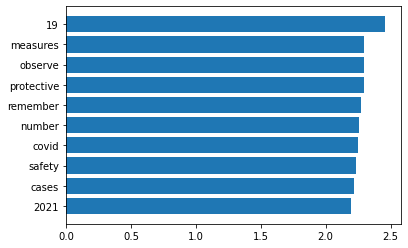

In [220]:
#printing values of highest words per topic
words1 = ['2021', 'cases', 'safety', 'covid', 'number', 'remember', 'protective', 'observe', 'measures', '19']

values1 = [2.197111, 2.221177, 2.234028, 2.251504, 2.258489, 2.275885, 2.294430, 2.295694, 2.298223, 2.456666]

plt.barh(words1, values1)

<BarContainer object of 10 artists>

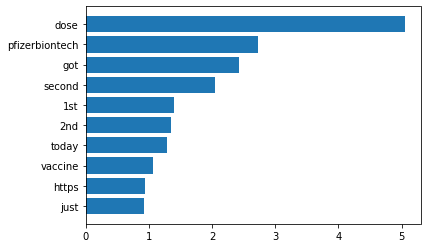

In [221]:
words2 = ['just', 'https', 'vaccine', 'today', '2nd', '1st', 'second', 'got', 'pfizerbiontech', 'dose']

values2 = [0.924487, 0.945368, 1.069171, 1.293177, 1.352024, 1.403267, 2.049525, 2.432165, 2.733258, 5.046109]

plt.barh(words2, values2)

<BarContainer object of 10 artists>

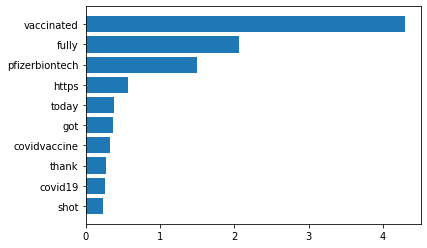

In [222]:
words3 = ['shot', 'covid19', 'thank', 'covidvaccine', 'got', 'today', 'https', 'pfizerbiontech', 'fully', 'vaccinated']

values3 = [0.237234, 0.253880, 0.274110, 0.324210, 0.366125, 0.385080, 0.572640, 1.494290, 2.061791, 4.287337]

plt.barh(words3, values3)

<BarContainer object of 10 artists>

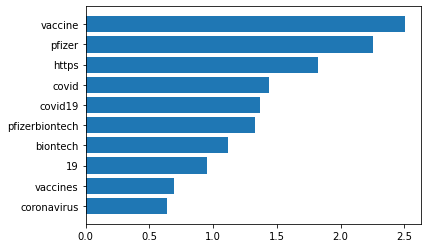

In [226]:
words4 = ['coronavirus', 'vaccines', '19', 'biontech', 'pfizerbiontech', 'covid19', 'covid', 'https', 'pfizer', 'vaccine']

values4 = [0.634183, 0.689090, 0.952644, 1.113698, 1.326259, 1.366579, 1.440518, 1.819813, 2.250979, 2.501085]

plt.barh(words4, values4)

In [206]:
# NMF topic modeling on user data
# document term matrix
X_user = doc_term
nmf_user = NMF(n_components=6, init='random', random_state=0)
W_user = nmf_user.fit_transform(X_user)
H_user = nmf_user.components_

In [207]:
W_user

array([[2.12065960e-03, 0.00000000e+00, 1.36666003e-29, 2.91996117e-04,
        1.61849660e-02, 4.86829573e-03],
       [1.08730998e-04, 0.00000000e+00, 7.61527750e-29, 1.47865422e-03,
        7.66309170e-04, 1.20651820e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.00069720e-99,
        0.00000000e+00, 0.00000000e+00],
       ...,
       [1.85827782e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.55516393e-06, 0.00000000e+00, 5.45082274e-30, 3.87898232e-04,
        1.99238336e-05, 1.55826996e-04],
       [1.85827782e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [208]:
H_user

array([[1.14804824e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.86439698e-29, 2.00546050e-29, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.22449851e-03, 2.98388898e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.56298334e-05, 6.22920232e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.27892199e-04, 5.37880157e-03, 2.51223787e-96, ...,
        6.12351760e-97, 2.40717641e-96, 2.00497750e-81]])

In [209]:
components_user_df = pd.DataFrame(nmf_user.components_, columns=vec.get_feature_names())
components_user_df

C:\Users\peter\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,00000000,007,00am,01,010,0114299999,0115,01252,...,𝚖𝚎𝚝𝚊𝚗𝚘𝚒𝚊,𝚗𝚊𝚖𝚎𝚍,𝚗𝚊𝚙𝚜,𝚜𝚝𝚊𝚢,𝚝𝚊𝚔𝚒𝚗𝚐,𝚝𝚎𝚊𝚖𝙱𝚛𝚢𝙰𝚗𝚗𝚎,𝚝𝚘,𝚠𝚊𝚗𝚝,𝟐𝐧𝐞𝟏,𝟸𝟺
0,1.148048e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,4.960754e-03,1.095231e-05,...,4.627595e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2.864397e-29,2.005460e-29,0.000000e+00,1.670259e-29,1.852073e-29,3.789619e-29,0.000000,0.000000,7.298038e-28,5.161709e-30,...,9.937009e-30,1.800943e-115,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1.224499e-03,2.983889e-03,0.000000e+00,4.931682e-05,6.798234e-05,4.604877e-04,0.000000,0.000000,0.000000e+00,3.574813e-05,...,3.187091e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,7.562983e-05,6.229202e-04,0.000000e+00,3.856942e-04,2.656200e-05,1.015704e-03,0.000000,0.000000,4.345345e-03,2.969184e-05,...,2.713620e-06,0.000000e+00,1.568944e-108,0.000000e+00,1.568944e-108,1.772514e-92,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,8.278922e-04,5.378802e-03,2.512238e-96,4.895748e-05,1.617370e-04,0.000000e+00,0.000906,0.000043,1.368222e-03,1.099695e-04,...,7.929403e-06,0.000000e+00,0.000000e+00,6.123518e-97,0.000000e+00,0.000000e+00,6.123518e-97,6.123518e-97,2.407176e-96,2.004978e-81


In [210]:
for topic in range(components_user_df.shape[0]):
    tmp = components_user_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
updates        1.529458
largest        1.528587
circulating    1.518611
thesundaily    1.518611
urban          1.502304
facebook       1.478779
breaking       1.473404
website        1.456363
instagram      1.415337
newspaper      1.394238
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
nan           3.369313e+00
cotswolds     4.568889e-44
mcr           4.568889e-44
rebellious    4.568889e-44
suburbs       4.568889e-44
produce       4.536474e-44
glasgow       4.536413e-44
londoner      4.488947e-44
catholic      4.475881e-44
manchester    4.428196e-44
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
nan              1.205228e+01
heelextension    7.265062e-25
mmvii            7.265062e-25
siya             7.265062e-25
za               7.265062e-25
gmail            7.210443e-25
com              6.773794e-25
contact          1.688973e-26
reporter         1.196573e-26
love             1

In [291]:
#text sentiment analysis
#vaderSentiment
sid_obj = SentimentIntensityAnalyzer()
sentiment_dict = sid_obj.polarity_scores(tweets['text'][1:1000])
print(sentiment_dict)

{'neg': 0.052, 'neu': 0.832, 'pos': 0.117, 'compound': 1.0}


In [287]:
sid_obj_1 = SentimentIntensityAnalyzer()
sentiment_dict_1 = sid_obj_1.polarity_scores(row_1['text'])
print(sentiment_dict_1)

{'neg': 0.125, 'neu': 0.766, 'pos': 0.109, 'compound': -0.1027}
